**Cell 1: Install Required Libraries**

In [1]:
!pip install transformers datasets accelerate wordcloud matplotlib

**Cell 2: Upload Your Lyrics File**

In [2]:
from google.colab import files

uploaded = files.upload()  # This will open a file picker

Saving wilson_lyrics.txt to wilson_lyrics.txt


**Cell 3: Load and Inspect the Data**

In [3]:
# Read the file
with open("wilson_lyrics.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Total characters:", len(text))
print("\nFirst 800 characters preview:\n")
print(text[:800])

Total characters: 28197

First 800 characters preview:

=== ARRIVING SOMEWHERE BUT NOT HERE ===

Never stop the car on a drive in the dark
Never look for the truth in your mother's eyes
Never trust the sound of rain upon a river rushing through your ears
Arriving somewhere, but not here
Did you imagine the final sound as a gun?
Or the smashing windscreen of a car?
Did you ever imagine the last thing you'd hear as you're fading out was a song?
Oh, oh, oh-oh, oh
Arriving somewhere, but not here
All my designs, simplified
And all of my plans, compromised
And all of my dreams, sacrificed
Ever had the feeling you've been here before?
Drinking down the poison the way you were taught
Ever thought from here on in your life begins and all you knew was wrong?
Oh, oh, oh-oh, oh
Arriving somewhere, but not here
All my designs, simplified
And all of my plan


**Cell 4: Create a Beautiful Word Cloud (Visualize Wilson’s Themes)**

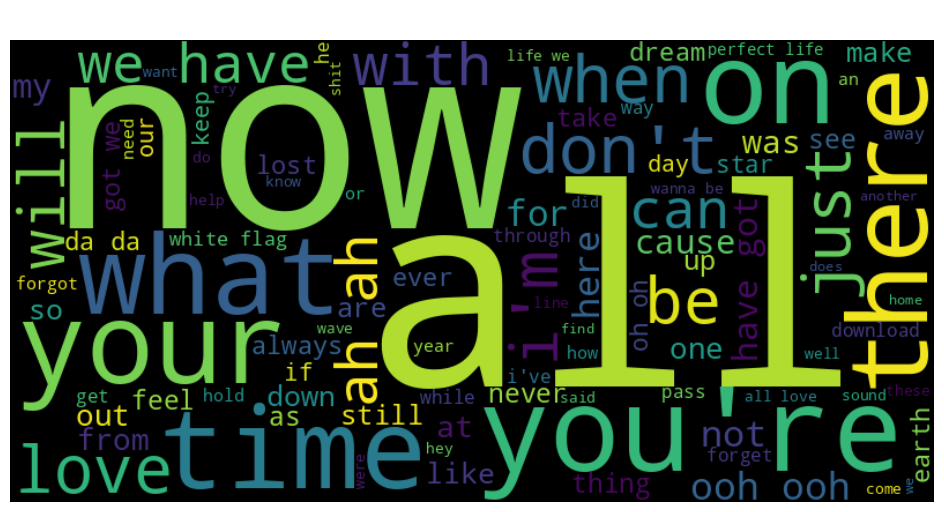

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=100,
    stopwords=["the", "and", "you", "that", "this", "a", "but", "to", "of", "in", "I", "it", "me", "no", "is"]  # basic English stopwords
).generate(text.lower())

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Steven Wilson's Lyrical World", fontsize=20, color="white")
plt.show()

**Cell 5: Prepare the Dataset for Training**

In [7]:
from datasets import Dataset
import re

# Basic cleaning
lines = [line.strip() for line in text.split("\n") if line.strip() and not line.startswith("===")]

# Join into one big string, or keep as lines — we'll use block text
full_text = "\n".join(lines)

# Create dataset
dataset = Dataset.from_dict({"text": [full_text]})

# We'll split into smaller chunks later during tokenization
print("Dataset ready with", len(full_text), "characters")

Dataset ready with 27529 characters


**Cell 6: Fine-Tune GPT-2 (The Actual Training!)**

In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import torch

# Enable device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device)

# Proper tokenization for causal language modeling
def tokenize_function(examples):
    # Tokenize and truncate to 512 (GPT-2 context size)
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding=False  # We'll pad dynamically
    )
    # For causal LM, labels are the same as input_ids
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator that handles dynamic padding and shifting
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # False = causal LM (not masked)
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./wilson_gpt2",
    overwrite_output_dir=True,
    num_train_epochs=8,                  # Increased a bit since dataset is small
    per_device_train_batch_size=2,       # Keep small for memory
    gradient_accumulation_steps=8,       # Effective batch size ~16
    warmup_steps=50,
    learning_rate=5e-5,
    logging_steps=20,
    save_steps=500,
    fp16=False,                          # Disable fp16 on CPU (causes issues)
    report_to="none",
    prediction_loss_only=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,         # This is the key fix!
)

# Start training
print("Starting training...")
trainer.train()

print("Training complete!")

Using device: cpu


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Starting training...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Training complete!


**Cell 7: Save the Model**

In [11]:
# Save model and tokenizer
model.save_pretrained("./wilson_gpt2_final")
tokenizer.save_pretrained("./wilson_gpt2_final")

# Download to your computer
from google.colab import files
!zip -r wilson_model.zip wilson_gpt2_final
files.download("wilson_model.zip")

  adding: wilson_gpt2_final/ (stored 0%)
  adding: wilson_gpt2_final/generation_config.json (deflated 24%)
  adding: wilson_gpt2_final/model.safetensors (deflated 7%)
  adding: wilson_gpt2_final/vocab.json (deflated 68%)
  adding: wilson_gpt2_final/merges.txt (deflated 53%)
  adding: wilson_gpt2_final/config.json (deflated 51%)
  adding: wilson_gpt2_final/tokenizer_config.json (deflated 56%)
  adding: wilson_gpt2_final/special_tokens_map.json (deflated 74%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Cell 8: Test Your New AI (Generate Lyrics!)**

In [12]:
from transformers import pipeline

generator = pipeline("text-generation", model="./wilson_gpt2_final", tokenizer=tokenizer, device=0 if device=="cuda" else -1)

# Test prompts
prompts = [
    "Time goes on",
    "Shadow on the window corner",
    "Keeps looking for the past",
    "There's a whisper in the air",
    "Night keeps getting longer and slower",
]

for prompt in prompts:
    output = generator(prompt, max_length=150, num_return_sequences=1, temperature=0.9, top_p=0.95)
    print("\n" + "="*50)
    print("Prompt:", prompt)
    print("Generated:\n" + output[0]["generated_text"])
    print("="*50)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Prompt: Time goes on
Generated:
Time goes on; he's got a lot of work to do, but he's got a lot to win. He's got a lot of work to do, too.

You know the way we treat them in the world, I really like them. They're a team that you love, and when they get in trouble, it's just fun to go out there and get your revenge, and they're going to do what they have to do. You go out there and do what you have to do, and you go out there and win.

And it's really fun to watch them win, to watch them do it.

MARC: When you see them in the ring, the fans are watching you, you've got this beautiful, nice, beautiful, awesome energy. You want to let them down?

DR: Yeah. I mean, if the fans come out to play this year, it's going to be a different year for them than it was back when I was here, and I think fans feel it's going to be even more different this year. They're going to feel like they have more potential, and they're going to be like, "Wow, I think I'm going to have that here."

M


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Prompt: Shadow on the window corner
Generated:
Shadow on the window corner of the house. After watching that, the next time we saw a new one, it would be in a far off house. And when the new one walked into the house, it would be like when you walk into a house of thieves. It would be as if you were inside a barn and someone stole a pig and the pig was killed. And the next time you saw it, it would be in a far off house. And when the next time we saw that one, it would be like when you walk into a house of thieves.

This is the case with all of this. I have tried to find out more, and I've just done it with a computer. But that computer is not as good as the one I have right now. I'm talking about the one that I have, the one I have that I have never made, I'm not able to see the screen, I can't see what's going on.

If you look at the old TV, the image is of a window in the middle of a garden. And the next thing you realize is, that window is in the middle of a garden. There was noth

Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Prompt: Keeps looking for the past
Generated:
Keeps looking for the past of the team with the likes of Tyler Toffoli and Brandon Pirri and they have two promising young prospects, as well. The Hurricanes are looking to build on the success of its recent wins, as the team has the most players playing consistently at a higher level, even in their older teams (which are currently 5-12). The team also needs to find a way to fit the young talent back into its starting lineup.

The Hurricanes, with the most offensive weapons and the fewest defensemen, have had a great season. The Hurricanes have had success in the back end of the offensive end of the field, with just three players on the team scoring at a high level during their seven games. There are a few options to move forward with the team, but the majority of the depth at center and right wing could help the team.

Miami's future at the NHL level is in doubt as the team has shown a few signs of growth and is looking for a top-four fin

Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Prompt: There's a whisper in the air
Generated:
There's a whisper in the air. There's a whisper at the other end of the tunnel, and they're all like "Fuck" and "Fuck that bitch," but I don't hear that. I'm like "Damn it, I could have just said that." And they're like "I would have been more excited to talk to you if you said that." It was like, "Who would you say? Who would you tell me that I love you?" It was hard to listen, but I had to listen to it and you really could see that. Like, "I have no idea what it is, but I know I can listen to you, and I can hear you." You'd be like, "Fuck you, fuck that bitch." So you could just have a great time."

Yeah, it's been good. It's been wonderful to listen to "I Love You" live. I've loved that album. You're on it now, and I know what you're thinking. I love it. It makes me feel like I can make love to you. Like, I hope you were not the only one.

You know, when we started in high school, I used to tell people the same story about what happen